# ONNX graph, single or double floats

The notebook shows discrepencies obtained by using double floats instead of single float in two cases. The second one involves [GaussianProcessRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.GaussianProcessRegressor.html).

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

## Simple case of a linear regression

A linear regression is simply a matrix multiplication followed by an addition: $Y=AX+B$. Let's train one with [scikit-learn](https://scikit-learn.org/stable/).

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
data = load_boston()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y)
clr = LinearRegression()
clr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [3]:
clr.score(X_test, y_test)

0.7754955458855879

In [4]:
clr.coef_

array([-9.62221179e-02,  3.97769669e-02,  2.41701192e-02,  1.71686963e+00,
       -1.84312581e+01,  3.80408374e+00,  4.42426441e-03, -1.49546082e+00,
        3.40876918e-01, -1.46762173e-02, -9.17680772e-01,  9.55019592e-03,
       -5.13600350e-01])

In [5]:
clr.intercept_

36.47803687780717

Let's predict with *scikit-learn* and *python*.

In [6]:
ypred = clr.predict(X_test)
ypred[:5]

array([12.48507816, 13.15696794, 31.20718141, 14.70775907,  8.52174843])

In [7]:
py_pred = X_test @ clr.coef_ + clr.intercept_
py_pred[:5]

array([12.48507816, 13.15696794, 31.20718141, 14.70775907,  8.52174843])

In [8]:
clr.coef_.dtype, clr.intercept_.dtype

(dtype('float64'), dtype('float64'))

## With ONNX

With *ONNX*, we would write this operation as follows... We still need to convert everything into single floats = float32.

In [9]:
%load_ext mlprodict

In [10]:
from skl2onnx.algebra.onnx_ops import OnnxMatMul, OnnxAdd
import numpy

onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float32)),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'])
onnx_model32 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float32)},
                              dtype=numpy.float32)

# add -l 1 if nothing shows up
%onnxview onnx_model32

The next line uses a python runtime to compute the prediction.

In [11]:
from mlprodict.onnxrt import OnnxInference
oinf = OnnxInference(onnx_model32)
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([12.485075 , 13.156963 , 31.207178 , 14.70776  ,  8.5217495],
      dtype=float32)

And here is the same with [onnxruntime](https://github.com/microsoft/onnxruntime)...

In [12]:
from mlprodict.tools.asv_options_helper import get_ir_version_from_onnx
# line needed when onnx is more recent than onnxruntime
onnx_model32.ir_version = get_ir_version_from_onnx()
oinf = OnnxInference(onnx_model32, runtime="onnxruntime1")
ort_pred = oinf.run({'X': X_test.astype(numpy.float32)})['Y']
ort_pred[:5]

array([12.485075 , 13.156963 , 31.207178 , 14.70776  ,  8.5217495],
      dtype=float32)

## With double instead of single float

[ONNX](https://onnx.ai/) was originally designed for deep learning which usually uses floats but it does not mean cannot be used. Every number is converted into double floats.

In [13]:
onnx_fct = OnnxAdd(OnnxMatMul('X', clr.coef_.astype(numpy.float64)),
                   numpy.array([clr.intercept_]),
                   output_names=['Y'])
onnx_model64 = onnx_fct.to_onnx({'X': X_test.astype(numpy.float64)},
                              dtype=numpy.float64)

And now the *python* runtime...

In [14]:
oinf = OnnxInference(onnx_model64)
ort_pred = oinf.run({'X': X_test})['Y']
ort_pred[:5]

array([12.48507816, 13.15696794, 31.20718141, 14.70775907,  8.52174843])

And the *onnxruntime* version of it, not fully supportive of double yet...

In [15]:
try:
    oinf = OnnxInference(onnx_model64, runtime="onnxruntime1")
    ort_pred = oinf.run({'X': X_test.astype(numpy.float64)})['Y']
    ort_pred[:5]
except RuntimeError as e:
    print(e)

Unable to create InferenceSession due to '[ONNXRuntimeError] : 2 : INVALID_ARGUMENT : Failed to load model with error: Unknown model file format version.'
ir_version: 7
producer_name: "skl2onnx"
producer_version: "1.6.995"
domain: "ai.onnx"
model_version: 0
graph {
  node {
    input: "X"
    input: "Ma_MatMulcst"
    output: "Ma_Y0"
    name: "Ma_MatMul"
    op_type: "MatMul"
    domain: ""
  }
  node {
    input: "Ma_Y0"
    input: "Ad_Addcst"
    output: "Y"
    name: "Ad_Add"
    op_type: "Add"
    domain: ""
  }
  name: "OnnxAdd"
  initializer {
    dims: 13
    data_type: 11
    name: "Ma_MatMulcst"
    double_data: -0.09622211792905919
    double_data: 0.03977696693789472
    double_data: 0.0241701192480088
    double_data: 1.716869634591464
    double_data: -18.431258070644905
    double_data: 3.804083741833037
    double_data: 0.004424264414403739
    double_data: -1.4954608202475637
    double_data: 0.34087691770262124
    double_data: -0.01467621729175423
    double_data: -0

## And now the GaussianProcessRegressor

This shows a case

In [16]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
gau = GaussianProcessRegressor(alpha=10, kernel=DotProduct())
gau.fit(X_train, y_train)

GaussianProcessRegressor(alpha=10, copy_X_train=True,
                         kernel=DotProduct(sigma_0=1), n_restarts_optimizer=0,
                         normalize_y=False, optimizer='fmin_l_bfgs_b',
                         random_state=None)

In [17]:
from mlprodict.onnx_conv import to_onnx
onnxgau32 = to_onnx(gau, X_train.astype(numpy.float32), dtype=numpy.float32)
oinf32 = OnnxInference(onnxgau32, runtime="python")
ort_pred32 = oinf32.run({'X': X_test.astype(numpy.float32)})['GPmean']
numpy.squeeze(ort_pred32)[:25]

array([13.125 , 14.25  , 32.375 , 18.5   , 11.875 , 19.875 , 27.    ,
       24.125 , 25.8125, 31.625 , 21.625 , 21.    , 26.1875, 16.6875,
       20.875 , 23.125 , 21.875 , 24.125 , 26.75  , 20.125 , 36.    ,
       22.    , 21.    , 21.6875,  8.625 ], dtype=float32)

In [18]:
onnxgau64 = to_onnx(gau, X_train.astype(numpy.float64), dtype=numpy.float64)
oinf64 = OnnxInference(onnxgau64, runtime="python")
ort_pred64 = oinf64.run({'X': X_test.astype(numpy.float64)})['GPmean']
numpy.squeeze(ort_pred64)[:25]

array([12.56445512, 14.36702446, 32.12489623, 18.18696708, 11.83999281,
       20.1427812 , 25.72875093, 23.47921428, 25.85952005, 31.1343177 ,
       21.14668927, 20.78586487, 25.67157909, 17.04368344, 20.40205231,
       23.1857285 , 20.80027975, 23.70270441, 26.38520145, 20.22776866,
       36.11386797, 21.89100091, 21.29767007, 22.34199677,  8.43756296])

The differences between the predictions for single floats and double floats...

In [19]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - ort_pred64)))[-5:]

array([0.71177439, 0.71719288, 0.77532736, 1.07472025, 1.27124907])

Who's right or wrong... The differences between the predictions with the original model...

In [20]:
pred = gau.predict(X_test.astype(numpy.float64))

In [21]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred32 - pred)))[-5:]

array([0.71177439, 0.71719288, 0.77532736, 1.07472025, 1.27124907])

In [22]:
numpy.sort(numpy.sort(numpy.squeeze(ort_pred64 - pred)))[-5:]

array([0., 0., 0., 0., 0.])

Double predictions clearly wins.

In [23]:
# add -l 1 if nothing shows up
%onnxview onnxgau64

## Saves...

Let's keep track of it.

In [24]:
with open("gpr_dot_product_boston_32.onnx", "wb") as f:
    f.write(onnxgau32.SerializePartialToString())
from IPython.display import FileLink
FileLink('gpr_dot_product_boston_32.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_32.onnx

In [25]:
with open("gpr_dot_product_boston_64.onnx", "wb") as f:
    f.write(onnxgau64.SerializePartialToString())
FileLink('gpr_dot_product_boston_64.onnx')

C:\xavierdupre\__home_\GitHub\mlprodict\_doc\notebooks\gpr_dot_product_boston_64.onnx

## Side by side

We may wonder where the discrepencies start. But for that, we need to do a side by side.

In [26]:
from mlprodict.onnxrt.validate.side_by_side import side_by_side_by_values
sbs = side_by_side_by_values([(oinf32, {'X': X_test.astype(numpy.float32)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])

from pandas import DataFrame
df = DataFrame(sbs)
# dfd = df.drop(['value[0]', 'value[1]', 'value[2]'], axis=1).copy()
df

,metric,step,v[0],v[1],cmp,name,value[0],shape[0],value[1],shape[1]
0,nb_results,-1,10,1.000000e+01,OK,NaN,NaN,NaN,NaN,NaN
1,abs-diff,0,0,4.902064e-08,OK,X,"[[25.0461, 0.0, 18.1, 0.0, 0.693, 5.987, 100.0...","(127, 13)","[[25.0461, 0.0, 18.1, 0.0, 0.693, 5.987, 100.0...","(127, 13)"
2,abs-diff,1,0,3.585329e-02,e<0.1,GPmean,"[[13.125, 14.25, 32.375, 18.5, 11.875, 19.875,...","(1, 127)","[[12.564455117331818, 14.367024457314983, 32.1...","(1, 127)"
3,abs-diff,2,0,5.553783e-08,OK,kgpd_MatMulcst,"[[0.04011, 0.01538, 0.05425, 0.16902, 14.2362,...","(13, 379)","[[0.04011, 0.01538, 0.05425, 0.16902, 14.2362,...","(13, 379)"
4,abs-diff,3,0,1.601856e-09,OK,kgpd_Addcst,[798.7988],"(1,)",[798.7988268454396],"(1,)"
5,abs-diff,4,0,5.064639e-08,OK,gpr_MatMulcst,"[-0.13448508, 0.7746184, -0.45382053, -0.12038...","(379,)","[-0.1344850845061791, 0.7746183600327846, -0.4...","(379,)"
6,abs-diff,5,0,0.000000e+00,OK,gpr_Addcst,[[0.0]],"(1, 1)",[[0.0]],"(1, 1)"
7,abs-diff,6,0,1.994481e-07,OK,kgpd_Y0,"[[381348.2, 320660.8, 363030.22, 288999.44, 61...","(127, 379)","[[381348.18680611637, 320660.8066715434, 36303...","(127, 379)"
8,abs-diff,7,0,1.994481e-07,OK,kgpd_C0,"[[381348.2, 320660.8, 363030.22, 288999.44, 61...","(127, 379)","[[381348.18680611637, 320660.8066715434, 36303...","(127, 379)"
9,abs-diff,8,0,1.994481e-07,OK,kgpd_output0,"[[381348.2, 320660.8, 363030.22, 288999.44, 61...","(127, 379)","[[381348.18680611637, 320660.8066715434, 36303...","(127, 379)"


The differences really starts for output ``'O0'`` after the matrix multiplication. This matrix melts different number with very different order of magnitudes and that alone explains the discrepencies with doubles and floats on that particular model.

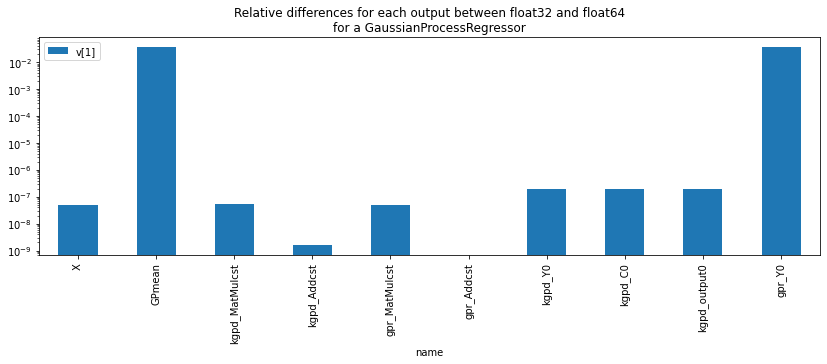

In [27]:
%matplotlib inline
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float32 and float64\nfor a GaussianProcessRegressor");

Before going further, let's check how sensitive the trained model is about converting double into floats.

In [28]:
pg1 = gau.predict(X_test)
pg2 = gau.predict(X_test.astype(numpy.float32).astype(numpy.float64))
numpy.sort(numpy.sort(numpy.squeeze(pg1 - pg2)))[-5:]

array([1.61747448e-06, 1.64913945e-06, 1.67055987e-06, 1.71677675e-06,
       2.22248491e-06])

Having float or double inputs should not matter. We confirm that with the model converted into ONNX.

In [29]:
p1 = oinf64.run({'X': X_test})['GPmean']
p2 = oinf64.run({'X': X_test.astype(numpy.float32).astype(numpy.float64)})['GPmean']
numpy.sort(numpy.sort(numpy.squeeze(p1 - p2)))[-5:]

array([1.61747448e-06, 1.64913945e-06, 1.67055987e-06, 1.71677675e-06,
       2.22248491e-06])

Last verification.

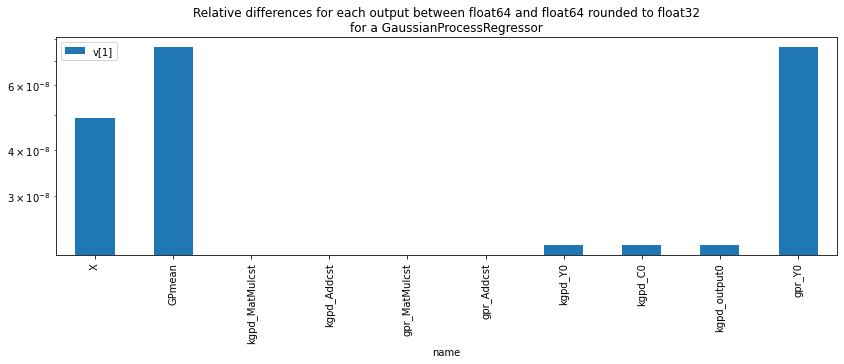

In [30]:
sbs = side_by_side_by_values([(oinf64, {'X': X_test.astype(numpy.float32).astype(numpy.float64)}),
                              (oinf64, {'X': X_test.astype(numpy.float64)})])
df = DataFrame(sbs)
ax = df[['name', 'v[1]']].iloc[1:].set_index('name').plot(kind='bar', figsize=(14,4), logy=True)
ax.set_title("Relative differences for each output between float64 and float64 rounded to float32"
             "\nfor a GaussianProcessRegressor");